In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
!pip install numpy==1.26.0
!pip install pillow==10.0.1
!pip install torch==1.13.1 torchvision functorch --extra-index-url https://download.pytorch.org/whl/cu117
!pip install tqdm==4.66.1

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 1.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 34.5 MB/s eta 0:00:00
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 103.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 104.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/24.3

In [ ]:
#!pip install torch==2.3.1+cu118 torchvision==0.16.2+cu118 --extra-index-url https://download.pytorch.org/whl/cu118
!pip install setuptools==69
!pip install git+https://github.com/NVlabs/tiny-cuda-nn/#subdirectory=bindings/torch

  Cloning https://github.com/NVlabs/tiny-cuda-nn/ to /tmp/pip-req-build-57rigdy9
  Running command git clone --filter=blob:none --quiet https://github.com/NVlabs/tiny-cuda-nn/ /tmp/pip-req-build-57rigdy9
  Resolved https://github.com/NVlabs/tiny-cuda-nn/ to commit c91138bcd4c6877c8d5e60e483c0581aafc70cce
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tinycudann
  Running setup.py clean for tinycudann
Failed to build tinycudann
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (tinycudann)


In [ ]:
import torch
import torch.nn as nn
import numpy as np

import os
import imageio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

dataset.py

In [ ]:
import torch
import numpy as np
import os
import imageio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

def get_rays(datapath, mode='train'):

    pose_file_names = [f for f in os.listdir(datapath + f'/{mode}/pose') if f.endswith('.txt')]
    intrisics_file_names = [f for f in os.listdir(datapath + f'/{mode}/intrinsics') if f.endswith('.txt')]
    img_file_names = [f for f in os.listdir(datapath + '/imgs') if mode in f]

    assert len(pose_file_names) == len(intrisics_file_names)
    assert len(img_file_names) == len(pose_file_names)

    # Read
    N = len(pose_file_names)
    poses = np.zeros((N, 4, 4))
    intrinsics = np.zeros((N, 4, 4))

    images = []

    for i in range(N):
        name = pose_file_names[i]

        pose = open(datapath + f'/{mode}/pose/' + name).read().split()
        poses[i] = np.array(pose, dtype=float).reshape(4, 4)

        intrinsic = open(datapath + f'/{mode}/intrinsics/' + name).read().split()
        intrinsics[i] = np.array(intrinsic, dtype=float).reshape(4, 4)

        # Read images
        img = imageio.imread(datapath + '/imgs/' + name.replace('txt', 'png')) / 255.
        images.append(img[None, ...])
    images = np.concatenate(images)

    H = images.shape[1]
    W = images.shape[2]

    if images.shape[3] == 4: #RGBA -> RGB
        images = images[..., :3] * images[..., -1:] + (1 - images[..., -1:])

    rays_o = np.zeros((N, H*W, 3))
    rays_d = np.zeros((N, H*W, 3))
    target_px_values = images.reshape((N, H*W, 3))

    for i in range(N):

        c2w = poses[i]
        f = intrinsics[i, 0, 0]

        u = np.arange(W)
        v = np.arange(H)
        u, v = np.meshgrid(u, v)
        dirs = np.stack((u - W / 2, -(v - H / 2), - np.ones_like(u) * f), axis=-1)
        dirs = (c2w[:3, :3] @ dirs[..., None]).squeeze(-1)
        dirs = dirs / np.linalg.norm(dirs, axis=-1, keepdims=True)

        rays_d[i] = dirs.reshape(-1, 3)
        rays_o[i] += c2w[:3, 3]

    return rays_o, rays_d, target_px_values

rendering.py

In [ ]:
import torch

def compute_accumulated_transmittance(betas):
    accumulated_transmittance = torch.cumprod(betas, 1)
    return torch.cat((torch.ones(accumulated_transmittance.shape[0], 1, device=accumulated_transmittance.device),
                      accumulated_transmittance[:, :-1]), dim=1)

def rendering(model, rays_o, rays_d, tn, tf, nb_bins=100, device='cpu', white_bckgr=True):

    t = torch.linspace(tn, tf, nb_bins).to(device) # [nb_bins]
    delta = torch.cat((t[1:] - t[:-1], torch.tensor([1e10], device=device)))

    x = rays_o.unsqueeze(1) + t.unsqueeze(0).unsqueeze(-1) * rays_d.unsqueeze(1) # [nb_rays, nb_bins, 3]

    colors, density = model.intersect(x.reshape(-1, 3), rays_d.expand(x.shape[1], x.shape[0], 3).transpose(0, 1).reshape(-1, 3))

    colors = colors.reshape((x.shape[0], nb_bins, 3)) # [nb_rays, nb_bins, 3]
    density = density.reshape((x.shape[0], nb_bins))

    alpha = 1 - torch.exp(- density * delta.unsqueeze(0)) # [nb_rays, nb_bins, 1]

    weights = compute_accumulated_transmittance(1 - alpha) * alpha # [nb_rays, nb_bins]

    if white_bckgr:
        c = (weights.unsqueeze(-1) * colors).sum(1) # [nb_rays, 3]
        weight_sum = weights.sum(-1) # [nb_rays]
        return c + 1 - weight_sum.unsqueeze(-1)
    else:
        c = (weights.unsqueeze(-1) * colors).sum(1) # [nb_rays, 3]

    return c

model.py

In [ ]:
import torch
import torch.nn as nn

class Voxels(nn.Module):

    def __init__(self, nb_voxels=100, scale=1, device='cpu'):
        super(Voxels, self).__init__()

        self.voxels = torch.nn.Parameter(torch.rand((nb_voxels, nb_voxels, nb_voxels, 4),
                                                    device=device, requires_grad=True))

        self.nb_voxels = nb_voxels
        self.device = device
        self.scale = scale

    def forward(self, xyz, d):

        x = xyz[:, 0]
        y = xyz[:, 1]
        z = xyz[:, 2]

        cond = (x.abs() < (self.scale / 2)) & (y.abs() < (self.scale / 2)) & (z.abs() < (self.scale / 2))

        indx = (x[cond] / (self.scale / self.nb_voxels) + self.nb_voxels / 2).type(torch.long)
        indy = (y[cond] / (self.scale / self.nb_voxels) + self.nb_voxels / 2).type(torch.long)
        indz = (z[cond] / (self.scale / self.nb_voxels) + self.nb_voxels / 2).type(torch.long)

        colors_and_densities = torch.zeros((xyz.shape[0], 4), device=xyz.device)
        colors_and_densities[cond, :3] = self.voxels[indx, indy, indz, :3]
        colors_and_densities[cond, -1] = self.voxels[indx, indy, indz, -1]

        return torch.sigmoid(colors_and_densities[:, :3]), torch.relu(colors_and_densities[:, -1:])


    def intersect(self, x, d):
        return self.forward(x, d)


class Nerf(nn.Module):

    def __init__(self, Lpos=10, Ldir=4, hidden_dim=256):
        super(Nerf, self).__init__()

        self.block1 = nn.Sequential(nn.Linear(Lpos * 6 + 3, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU())

        self.block2 = nn.Sequential(nn.Linear(hidden_dim + Lpos * 6 + 3, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim + 1),)

        self.rgb_head = nn.Sequential(nn.Linear(hidden_dim + Ldir * 6 + 3, hidden_dim // 2), nn.ReLU(),
                                      nn.Linear(hidden_dim // 2, 3), nn.Sigmoid())

        self.Lpos = Lpos
        self.Ldir = Ldir

    def positional_encoding(self, x, L):
        out = [x]
        for j in range(L):
            out.append(torch.sin(2 ** j * x))
            out.append(torch.cos(2 ** j * x))
        return torch.cat(out, dim=1)



    def forward(self, xyz, d):

        x_emb = self.positional_encoding(xyz, self.Lpos) # [batch_size, Lpos * 6 + 3]
        d_emb = self.positional_encoding(d, self.Ldir) # [batch_size, Ldir * 6 + 3]

        h = self.block1(x_emb) # [batch_size, hidden_dim]
        h = self.block2(torch.cat((h, x_emb), dim=1)) # [batch_size, hidden_dim + 1]
        sigma = h[:, -1]
        h = h[:, :-1] # [batch_size, hidden_dim]
        c = self.rgb_head(torch.cat((h, d_emb), dim=1))

        return c, torch.relu(sigma)


    def intersect(self, x, d):
        return self.forward(x, d)

ml_helpers

In [ ]:
from tqdm import tqdm
import torch

def training(model, optimizer, scheduler, tn, tf, nb_bins, nb_epochs, data_loader, device='cpu'):

    training_loss = []
    epoch_loss = []
    for epoch in (range(nb_epochs)):
        for batch in tqdm(data_loader):
            o = batch[:, :3].to(device)
            d = batch[:, 3:6].to(device)

            target = batch[:, 6:].to(device)

            prediction = rendering(model, o, d, tn, tf, nb_bins=nb_bins, device=device)

            loss = ((prediction - target)**2).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            training_loss.append(loss.item())

        scheduler.step()

        torch.save(model.cpu(), 'model_nerf')
        model.to(device)

    return training_loss

## Reconstrucción

In [ ]:
batch_size = 1024

o, d, target_px_values = get_rays('/content/drive/MyDrive/apple_render', mode='train')
dataloader = DataLoader(torch.cat((torch.from_numpy(o).reshape(-1, 3).type(torch.float),
                                   torch.from_numpy(d).reshape(-1, 3).type(torch.float),
                                   torch.from_numpy(target_px_values).reshape(-1, 3).type(torch.float)), dim=1),
                       batch_size=batch_size, shuffle=True)


dataloader_warmup = DataLoader(torch.cat((torch.from_numpy(o).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3).type(torch.float),
                               torch.from_numpy(d).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3).type(torch.float),
                               torch.from_numpy(target_px_values).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3).type(torch.float)), dim=1),
                       batch_size=batch_size, shuffle=True)


test_o, test_d, test_target_px_values = get_rays('/content/drive/MyDrive/apple_render', mode='test')

<ipython-input-8-251ad5c990f5>:34: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(datapath + '/imgs/' + name.replace('txt', 'png')) / 255.


# Training

In [ ]:
device = 'cuda'

tn = 8.
tf = 12.
nb_epochs = 10
lr = 1e-3
gamma = .5
nb_bins = 100

model = Nerf(hidden_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10], gamma=gamma)



training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, 1, dataloader_warmup, device=device)
plt.plot(training_loss)
plt.show()
training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, nb_epochs, dataloader, device=device)
plt.plot(training_loss)
plt.show()

NameError: name 'Nerf' is not defined

In [ ]:
torch.save(model, 'model_nerf')

# Volumetric Rendering

In [ ]:
def mse2psnr(mse):
    return 20 * np.log10(1 / np.sqrt(mse))


@torch.no_grad()
def test(model, o, d, tn, tf, nb_bins=100, chunk_size=10, H=400, W=400, target=None):

    o = o.chunk(chunk_size)
    d = d.chunk(chunk_size)

    image = []
    for o_batch, d_batch in zip(o, d):
        img_batch = rendering(model, o_batch, d_batch, tn, tf, nb_bins=nb_bins, device=o_batch.device)
        image.append(img_batch) # N, 3
    image = torch.cat(image)
    image = image.reshape(H, W, 3).cpu().numpy()

    if target is not None:
        mse = ((image - target)**2).mean()
        psnr = mse2psnr(mse)

    if target is not None:
        return image, mse, psnr
    else:
        return image

In [ ]:
img, mse, psnr = test(model, torch.from_numpy(test_o[9]).to(device).float(), torch.from_numpy(test_d[9]).to(device).float(),
                tn, tf, nb_bins=100, chunk_size=10, target=test_target_px_values[9].reshape(400, 400, 3))

print(psnr)

39.98407969564544


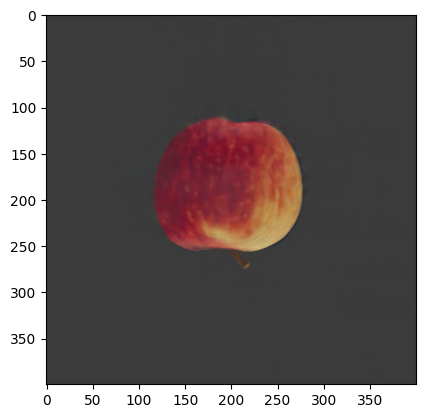

In [ ]:
plt.imshow(img)